Please refer to files Verlet_s_orbitals and p_orbitals_1 for detailed explanation of Verlet method. 

Now that we have the Verlet integrator function, we can use it in the shooting/bisection method. 
  
Flowchart for the shooting/bisection method:
1. Set an initial guess for the eigenvalue E called E1
2. Set a value called called E2 (for Bisection purposes)
3. Set a dE variable to modify E, where E2 = E1 + dE
4. Calculate f with the initial E1 guess
5. Define delta_0 as the difference between f and required condition at the last index
6. Calculate f again but with E2 guess
7. Define delta_2 as the difference between this f and required condition at the last index
8. If delta_2 is within the tolerance E2 is the answer; break
9. If delta_0 and delta_2 have different signs, bisect
10. E = (E1 + E2)/2 
11. Run Verlet to calculate f again
12. Repeat from step 6
13. If delta_0 and delta_2 have the same sign, then assign E1 = E2 and increment E2 by dE
14. Can check for edge cases along the way

n =  1  l =  0


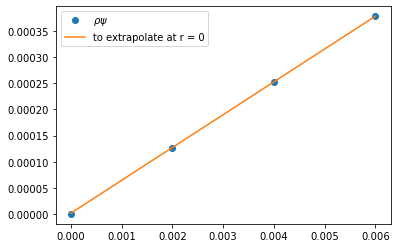

EigenEnergy is  -1.0 !!!!!!!!!!!!!!!


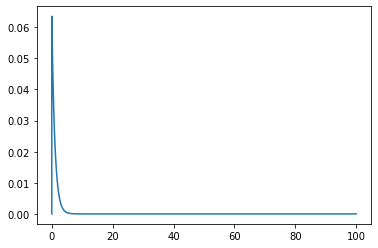

n =  2  l =  0
n =  2  l =  1
n =  3  l =  0
n =  3  l =  1
n =  3  l =  2


In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
# Alias scipy as sp
import scipy as sp
# scipy.optimize for the curve_fit function
import scipy.optimize
import math

# define rho
totrho = 5*10**4
rho_min = 0
rho_max = 100
rho = np.linspace(rho_min, rho_max, totrho)

def Verlet(epsilon, l):
    # defining rho range
    totrho = 5*10**4
    rho_min = 0
    rho_max = 100
    rho = np.linspace(rho_min, rho_max, totrho)
    drho = (rho_max)/(totrho)
    
    # initialize a zero list of the wavefunction of length rho
    length = totrho
    f = [0]*length
   
    # set the end values of f; mind the indexing 
    f[length - 1] = 0
    f[length - 2] = 10**-10
    
    for i in range(length-2, 1, -1):
        f[i-1] = 2*f[i] - f[i+1] + drho**2*(-epsilon - 2/rho[i] + l*(l+1)/(rho[i]**2))*f[i]
    
    #print('this is f', f)
    
    psi= [0]*length
    # solve for psi - wavefunction
    for i in range(1, length, 1):
        psi[i] = f[i]/rho[i]
    
    # normalize the wavefunction f
    # find the total sum (A) of all points of f
    A = 0 
    for i in range(length):
        A += psi[i]**2 # should be some factors of pi likely

    Norm = np.sqrt(A)
    psi = [x/Norm for x in psi]
    return psi # normalized wavefunction 

# From Feynman's hydrogen lecture + Molecular symmetries by David Willock
def theory(n, l):
    totrho = 5*10**4
    rho_min = 0
    rho_max = 100
    rho = np.linspace(rho_min, rho_max, totrho)
    
    if l == 0:
        # coefficients in front of rho
        a = [0]*n
        a[0] = 1
        for i in range(1, n, 1):
            k = i
            a[i] = 2*(k/n -1)/(k*(k+1))*a[i-1]
    
        # multiply element-wise by rho^k
        g = [0]*totrho
        for i in range(totrho):
            for k in range(n):
                g[i] += a[k]*rho[i]**(k+1)
        # calculating psi
        psi = np.exp(-rho[1::]/n)/rho[1::]*g[1::]
                
    if l == 1:
        if n == 2:
            psi = rho*np.exp(-rho/n)
        elif n == 3:
            psi = (4-2/n*rho)*(2/n)*rho*np.exp(-rho/n)
    elif l == 2:
        psi = 1/n**2*rho**2*np.exp(-rho/n)

    A = sum([x**2 for x in psi])
    psi_n = [x/np.sqrt(A) for x in psi]
    return psi_n

# Extrapolate psi(r=0) with psi(r=1,2,3)
def fit(x, m, b):
    return m*x + b

def extrapolate(x, y):
    x = x[1:4]
    y = y[1:4]
    pOpt1, pCov1 = sp.optimize.curve_fit(fit, x, y*x, p0=(1, 1))
    #plt.plot(x, y*x, 'o', label = '$\\rho\psi$')
    #plt.plot(x, fit(x, pOpt1[0], pOpt1[1]), label = 'to extrapolate at r = 0')
    #plt.legend()
    #plt.show()
    return pOpt1[1]

# Begin main - Shooting/Bisection

# Allocate variable to hold solution

En = [0]*6
psi_n = [[0 for x in range(totrho)] for y in range(6)] 

# Allocate variable to hold the difference between solution and BC
delta = [0]*2

# Define initial guess and increments
E1 = -1.1 
dE = 0.01
E2 = E1 + dE

# Define boundary condition 
rhopsiBC_0 = 0

# Define tolerances
tolerance_min = 10**-7

# set up boolean 
Bisecting = False

# Calculate the wavefunction with initial guess
psi = Verlet(E1, 0)

# Define the difference between required BC and our extrapolated BC
rhopsi_0 = extrapolate(rho, psi)
delta[0] = rhopsi_0 - rhopsiBC_0

# keeping track of the number of solutions
count = 0 

for n in range(3):
    n += 1
    
    for l in range(3):
        if l >= n:
            continue
        print('n = ', n, ' l = ', l)
        
        for i in range(10**3):
    
            #print('****** iteration', i, '******n =', n, 'l = ', l)
            # set up for E variables for iterations (incrementing energies)
            if not Bisecting:
                E = E2
                #print('not bisecting')
            if Bisecting:
                E = 0.5*(E1 + E2) 
                #print('bisecting')
            #print('E1, E2, and E are:')
            #print(E1, E2, E)
            # Calculate the wavefunction again with E2
            psi = Verlet(E, l)

            # Define the difference between required BC and second extrapolated BC
            rhopsi_0 = extrapolate(rho, psi)
            delta[1] = rhopsi_0 - rhopsiBC_0
    
            #print('delta[0] and delta[1] are:')
            #print(delta[0], delta[1])
    
            if (E == -1 or E == -0.97) and (n == 1 and l == 0):
                x = rho[1:4]
                y = psi[1:4]
                pOpt1, pCov1 = sp.optimize.curve_fit(fit, x, y*x, p0=(1, 1))
                plt.plot(rho[0:4], (rho*psi)[0:4], 'o', label = '$\\rho\psi$')
                plt.plot(rho[0:4], fit(rho[0:4], pOpt1[0], pOpt1[1]), label = 'to extrapolate at r = 0')
                plt.legend()
                plt.show()
        
    
            # Determine how to increment E in each case
    
            # found the answer 
            if abs(delta[1]) < tolerance_min:
                # Store and plot data
                count += 1
                En[count-1] = E
                psi_n[count-1][:] = psi
                print('EigenEnergy is ', En[count-1], '!!!!!!!!!!!!!!!')
                plt.plot(rho, psi_n[count-1][:])
                plt.show()
                
                # prepare the E for the next energy eigenvalue
                E1 = E + dE/100
                E2 = E1 + dE
                
                # prepare boolean and continue iterative setup 
                Bisecting = False
                delta[0] = delta[1] 
                break 
         
    
            # If the last step was already a bisection (the next step will be too): change the energy variables
            if Bisecting:
                if abs(E1 - E) > abs(E2 - E):
                    E2 = E
                else:
                    E1 = E
                
    
            # If the last step was not a bisection but the next one requires one
            if not Bisecting and delta[0]*delta[1] < 0:
                Bisecting = True
                #print(1)
        
            # Turn Bisecting boolean to true if the two deltas straddle 0 
            if delta[0]*delta[1] < 0:
                Bisecting = True # Bisect
                #print('bisection next step')
        
            if not Bisecting:
                E1 = E2
                E2 += dE
                #print('no bisection')
        
            if i == 10**3-1:
                print('Max iterations reached, please change your initial guess.')
    
            if E >= 0:
                print('No solution found.')
    
        
            # switch over the values to keep up with the energy steps
            delta[0] = delta[1]    
            #print("                    ")



Flowchart for the shooting/bisection method:
1. Set an initial guess for the eigenvalue E called E1
2. Set a value called called E2 (for Bisection purposes)
3. Set a dE variable to modify E, where E2 = E1 + dE
4. Calculate f with the initial E1 guess
5. Define delta_0 as the difference between f and required condition at the last index (after extrapolating)
6. Calculate f again but with E2 guess
7. Define delta_2 as the difference between this f and required condition at the last index
8. If delta_2 is within the tolerance E2 is the answer; break
9. If delta_0 and delta_2 have different signs, bisect
10. E = (E1 + E2)/2 
11. Run Verlet to calculate f again
12. Repeat from step 6
13. If delta_0 and delta_2 have the same sign, then assign E1 = E2 and increment E2 by dE
14. Can check for edge cases along the way